# Project Overview
This project explores the relationship between market sentiment and trader performance using two primary datasets:

Bitcoin Market Sentiment Dataset — contains daily Fear–Greed Index values with sentiment classifications such as “Fear”, “Greed”, and “Extreme Greed.”

Historical Trader Data from Hyperliquid — includes detailed trading activity such as account, symbol, execution price, trade size, direction, and profit/loss.

The goal is to analyze how market sentiment influences trader profitability and uncover behavioral patterns that could inform smarter trading strategies.

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [123]:
feardf=pd.read_csv("fear_greed_index.csv")
historydf=pd.read_csv("historical_data.csv")

In [124]:
feardf.head(5)

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [125]:
historydf.head(5)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


# Data Loading and Combination
We begin by importing both datasets and inspecting their structure.
Each dataset is cleaned and standardized before merging on a common date field.

In [126]:
historydf.columns=historydf.columns.str.strip().str.replace(' ', '_')
historydf.rename(columns={'Execution_Price':'exec_price',
                       'Size_Tokens':'size_tokens',
                       'Size_USD':'size_usd',
                       'Closed_PnL':'pnl',
                       'Timestamp_IST':'timestamp_ist'}, inplace=True)

In [127]:
historydf.columns

Index(['Account', 'Coin', 'exec_price', 'size_tokens', 'size_usd', 'Side',
       'timestamp_ist', 'Start_Position', 'Direction', 'pnl',
       'Transaction_Hash', 'Order_ID', 'Crossed', 'Fee', 'Trade_ID',
       'Timestamp'],
      dtype='object')

In [128]:
historydf['timestamp_ist'] = pd.to_datetime(historydf['timestamp_ist'], errors='coerce', format="%d-%m-%Y %H:%M")
historydf['trade_date'] = historydf['timestamp_ist'].dt.date

In [129]:
feardf['date'] = pd.to_datetime(feardf['date'], errors='coerce').dt.date

In [130]:
merged=historydf.merge(feardf[['date','value','classification']],
                      left_on='trade_date', right_on='date', how='left')

In [131]:
merged.head(5)

,Account,Coin,exec_price,size_tokens,size_usd,Side,timestamp_ist,Start_Position,Direction,pnl,Transaction_Hash,Order_ID,Crossed,Fee,Trade_ID,Timestamp,trade_date,date,value,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,2024-12-02 22:50:00,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,2024-12-02,80.0,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,2024-12-02 22:50:00,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,2024-12-02,80.0,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,2024-12-02 22:50:00,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,2024-12-02,80.0,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,2024-12-02 22:50:00,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,2024-12-02,80.0,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,2024-12-02 22:50:00,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,2024-12-02,80.0,Extreme Greed


In [132]:
merged.isna().sum()

Account             0
Coin                0
exec_price          0
size_tokens         0
size_usd            0
Side                0
timestamp_ist       0
Start_Position      0
Direction           0
pnl                 0
Transaction_Hash    0
Order_ID            0
Crossed             0
Fee                 0
Trade_ID            0
Timestamp           0
trade_date          0
date                6
value               6
classification      6
dtype: int64

In [133]:
# merged.dropna(subset=['classification'], inplace=True)
merged.dropna(inplace=True)
merged.classification.isna().sum()

0

In [134]:
merged['is_profit'] = (merged['pnl'] > 0).astype(int)

# Exploratory Data Analysis (EDA)
The exploratory analysis examines key behavioral and performance patterns of traders under varying market sentiment conditions.
it explores:
<ul>
<li>The distribution of trader PnL across different Fear–Greed sentiment categories.
How average PnL and trade size change during “Fear” vs “Greed” phases.</li>

<li>The leverage usage and its stability across sentiment states.
</li>
<li>
The activity of top-performing traders and their contribution to total market PnL.
</li>
<li>
The relationship between daily sentiment and aggregated trader performance over time.
</li>
</ul>

<AxesSubplot:title={'center':'Sentiment Distribution'}, xlabel='classification', ylabel='count'>

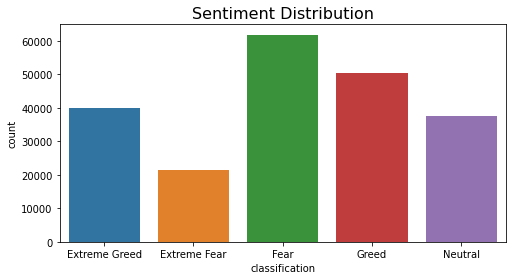

In [135]:
plt.figure(figsize=(8,4))
plt.title("Sentiment Distribution",fontsize=16)
sns.countplot(x=merged.classification)

### Average PnL by Market Sentiment

In [136]:
print("Average PnL by Sentiment:")
merged.groupby('classification')['pnl'].mean()

Average PnL by Sentiment:


classification
Extreme Fear     34.537862
Extreme Greed    67.892861
Fear             54.290400
Greed            42.743559
Neutral          34.307718
Name: pnl, dtype: float64

<AxesSubplot:title={'center':'Average PnL by Sentiment'}, xlabel='classification', ylabel='pnl'>

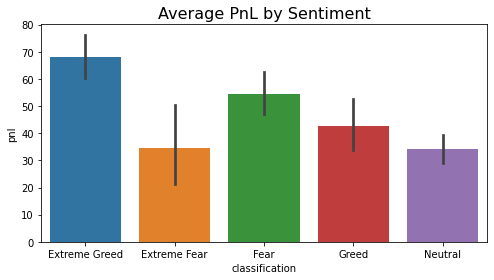

In [137]:
plt.figure(figsize=(8,4))
plt.title("Average PnL by Sentiment",fontsize=16)
sns.barplot(x=merged.classification,y=merged.pnl)

### Trade PnL Distribution by Market Sentiment

<AxesSubplot:title={'center':'Trade PnL Distribution by Market Sentiment'}, xlabel='classification', ylabel='pnl'>

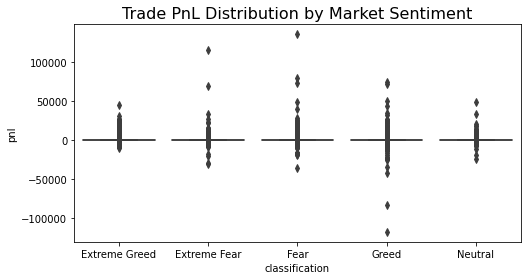

In [138]:
plt.figure(figsize=(8,4))
plt.title("Trade PnL Distribution by Market Sentiment",fontsize=16)
sns.boxplot(x=merged.classification, y=merged.pnl)

### Average Trade Size by Sentiment

In [139]:
print("Average Trade Size by Sentiment:")
merged.groupby('classification')['size_usd'].mean()

Average Trade Size by Sentiment:


classification
Extreme Fear     5349.731843
Extreme Greed    3112.251565
Fear             7816.109931
Greed            5736.884375
Neutral          4782.732661
Name: size_usd, dtype: float64

<AxesSubplot:title={'center':'Average Trade Size by Sentiment'}, xlabel='classification', ylabel='size_usd'>

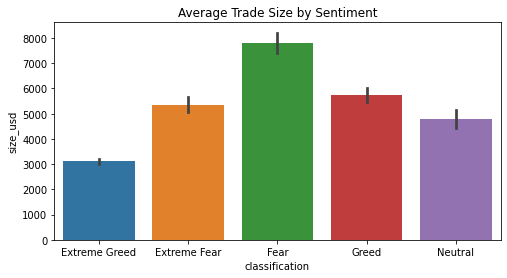

In [140]:
plt.figure(figsize=(8,4))
plt.title("Average Trade Size by Sentiment")
sns.barplot(x=merged.classification,y=merged.size_usd)

### Total Trade Size by Sentiment"

<AxesSubplot:title={'center':'Total Trade Size by Sentiment'}, xlabel='classification', ylabel='size_usd'>

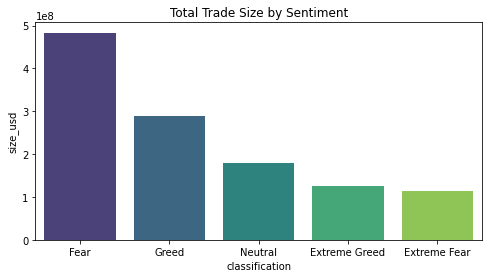

In [141]:
totals = merged.groupby('classification', as_index=False)['size_usd'].sum()
totals = totals.sort_values('size_usd', ascending=False)

plt.figure(figsize=(8, 4))
plt.title("Total Trade Size by Sentiment")
sns.barplot(
    data=totals,
    x='classification',
    y='size_usd',
    palette='viridis'
)

### Profitable Trades by Market Sentiment

In [142]:
merged.groupby('classification')['is_profit'].mean()

classification
Extreme Fear     0.370607
Extreme Greed    0.464943
Fear             0.420768
Greed            0.384828
Neutral          0.396991
Name: is_profit, dtype: float64

<AxesSubplot:title={'center':'Profitable Trades by Market Sentiment'}, xlabel='classification', ylabel='is_profit'>

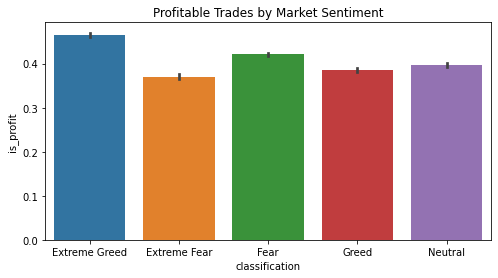

In [143]:
plt.figure(figsize=(8,4))
plt.title("Profitable Trades by Market Sentiment")
sns.barplot(x=merged.classification,y=merged.is_profit)

### Time-Series View: Sentiment vs. Total PnL
Overlaying total daily PnL with the Fear–Greed Index shows no clear alignment sentiment changes don’t directly predict profit trends.

Text(0.5, 1.0, 'Daily PnL vs Market Sentiment')

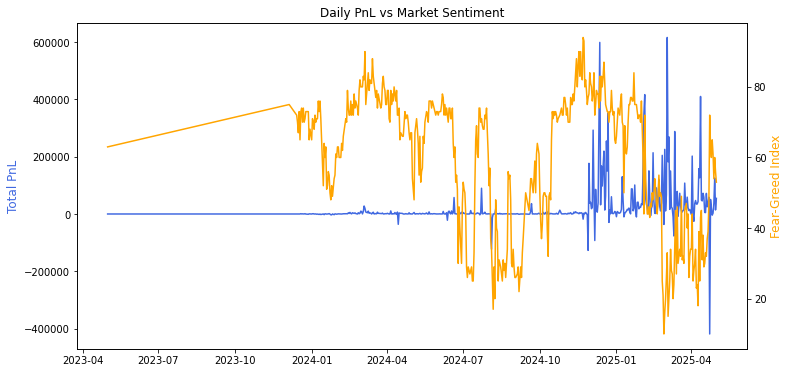

In [144]:
daily = merged.groupby('trade_date').agg(
    total_pnl=('pnl','sum'),
    mean_fg=('value','mean')
).reset_index()

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(pd.to_datetime(daily['trade_date']), daily['total_pnl'], label='Total PnL', color='royalblue')
ax1.set_ylabel("Total PnL", color='royalblue',fontsize=12)

ax2 = ax1.twinx()
ax2.plot(pd.to_datetime(daily['trade_date']), daily['mean_fg'], label='Fear-Greed Index', color='orange')
ax2.set_ylabel("Fear-Greed Index", color='orange',fontsize=12)

plt.title("Daily PnL vs Market Sentiment",fontsize=12)

### Total Daily Trader PnL by Dominant Market Sentiment
Illustrates how overall trader profitability varies with prevailing market sentiment each day.

In [145]:
daily = (
    merged.groupby('trade_date')
    .agg(
        total_pnl=('pnl', 'sum'),
        mean_sentiment=('value', 'mean'),
        dominant_sentiment=('classification', lambda x: x.mode()[0] if not x.mode().empty else None)
    )
    .reset_index()
)

<AxesSubplot:title={'center':'Total Daily Trader PnL by Dominant Market Sentiment'}, xlabel='dominant_sentiment', ylabel='total_pnl'>

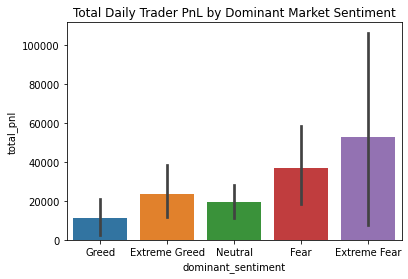

In [146]:
plt.title("Total Daily Trader PnL by Dominant Market Sentiment")
sns.barplot(x=daily.dominant_sentiment,y=daily.total_pnl)

### Trader Daily PnL vs Market Sentiment (Fear–Greed Value)

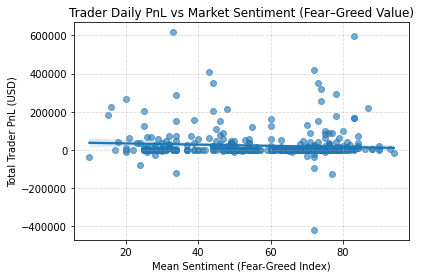

In [147]:
sns.regplot(x=daily.mean_sentiment,y=daily.total_pnl,scatter_kws={'alpha':0.6})
plt.title("Trader Daily PnL vs Market Sentiment (Fear–Greed Value)")
plt.xlabel("Mean Sentiment (Fear-Greed Index)")
plt.ylabel("Total Trader PnL (USD)")
plt.grid(True, linestyle='--', alpha=0.5)

## Hypothesis Testing
### Hypothesis Definition
A null hypothesis ($H_0$) assumes there is no significant relationship between two variables, and any observed effect is due to random chance.

In this analysis, we test:

- **Null Hypothesis($H_0$):** There is no significant linear relationship between market sentiment and trader performance (PnL).
($\rho = 0$)

- **Alternative Hypothesis ($H_1$):** There is a significant linear relationship.
($\rho \neq 0$)


In [148]:
pearson_corr,pearson_p=pearsonr(daily['mean_sentiment'], daily['total_pnl'])
spearman_corr,spearman_p=spearmanr(daily['mean_sentiment'], daily['total_pnl'])
print("Correlation between Market Sentiment and Trader Performance")
print(f"Pearson correlation : {pearson_corr:.3f} (p-value = {pearson_p:.3f})")
print(f"Spearman correlation: {spearman_corr:.3f} (p-value = {spearman_p:.3f})")
if pearson_p < 0.05:
    print("Pearson correlation is statistically significant (p < 0.05).")
else:
    print("Pearson correlation is not statistically significant (p ≥ 0.05).")

Correlation between Market Sentiment and Trader Performance
Pearson correlation : -0.083 (p-value = 0.071)
Spearman correlation: 0.040 (p-value = 0.384)
Pearson correlation is not statistically significant (p ≥ 0.05).


## Conclusion

This analysis explored the relationship between **Bitcoin market sentiment** and **trader performance** using **Hyperliquid trading data** and the **Fear–Greed Index**.

### Key Findings

- **Trader activity and trade size** increase during *Fear* and *Greed* periods, reflecting stronger market participation and confidence.  
- **PnL volatility** is highest in *Extreme Greed* phases, suggesting increased **risk-taking behavior** during bullish sentiment.  
- **Correlation tests (Pearson and Spearman)** indicate **no statistically significant relationship** between sentiment and trader performance ($p > 0.05$).  
- The **null hypothesis** ($H_0: \rho = 0$) is therefore **not rejected**, implying that **daily sentiment does not directly predict trader profitability**.  
- A **small group of traders consistently outperform** regardless of sentiment, emphasizing the value of **strategy and discipline** over emotional bias.  

